#Two layered nn using jax on Mnist Data set




In [56]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

In [57]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 10, 128, 10] # we tried with several number of sets like [784,10,10,10], [784, 128, 128, 10], [784,128,64,10], [784,128,10,10],[784,10,128,10] we place the loss function plot
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))
params

[(DeviceArray([[-0.00476654,  0.0174511 ,  0.00820192, ...,  0.00420483,
                 0.01661447, -0.00711814],
               [-0.01871746,  0.00429217,  0.01709598, ...,  0.005661  ,
                 0.00943259,  0.0075941 ],
               [-0.010374  ,  0.01708133, -0.02524053, ..., -0.00577776,
                -0.00016799,  0.00135036],
               ...,
               [-0.01151889, -0.00757259,  0.01090092, ..., -0.01054432,
                -0.01063822,  0.00815061],
               [ 0.00567098, -0.01304589,  0.02454334, ..., -0.00065788,
                 0.00192191, -0.01061198],
               [ 0.00530932, -0.00761684,  0.01144118, ...,  0.02284464,
                -0.01568104,  0.00418428]], dtype=float32),
  DeviceArray([-0.01062579, -0.00319807,  0.01910353, -0.0013924 ,
               -0.01968765, -0.02294103, -0.00881463, -0.01330986,
                0.00571147,  0.0076695 ], dtype=float32)),
 (DeviceArray([[-0.00065035, -0.01186085,  0.01075825, ...,  0.00920764,
 

In [58]:
from jax.scipy.special import logsumexp
#defining the relu function
def relu(x):
  return jnp.maximum(0, x)
#prediction function
def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  a=logits - logsumexp(logits)
  return a

In [59]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [60]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


In [61]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


In [62]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [63]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [64]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

The usual mnist data set has a split of train data close to 80:20 so we didn't split it

In [65]:
# Get the full train dataset (for checking accuracy while training) 
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [66]:
import time
loss_map=np.zeros(num_epochs, object)
for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in training_generator:
    y = one_hot(y, n_targets)
    params = update(params, x, y)
  epoch_time = time.time() - start_time
  train_loss = loss(params, train_images, train_labels)
  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))
  print(train_loss)
  loss_map[epoch] = (epoch, train_loss )
  
print(loss_map)

Epoch 0 in 3.95 sec
Training set accuracy 0.8021500110626221
Test set accuracy 0.8053999543190002
0.06537513
Epoch 1 in 3.35 sec
Training set accuracy 0.8770000338554382
Test set accuracy 0.8793999552726746
0.041290984
Epoch 2 in 3.26 sec
Training set accuracy 0.8947333693504333
Test set accuracy 0.8949999809265137
0.035928067
Epoch 3 in 3.24 sec
Training set accuracy 0.9031167030334473
Test set accuracy 0.9027999639511108
0.03307914
Epoch 4 in 3.38 sec
Training set accuracy 0.9090166687965393
Test set accuracy 0.9081999659538269
0.030935371
Epoch 5 in 3.29 sec
Training set accuracy 0.9146666526794434
Test set accuracy 0.9126999974250793
0.029094286
Epoch 6 in 3.35 sec
Training set accuracy 0.9199833273887634
Test set accuracy 0.9168999791145325
0.02745781
Epoch 7 in 3.28 sec
Training set accuracy 0.9239667057991028
Test set accuracy 0.9211999773979187
0.026069736
[(0, DeviceArray(0.06537513, dtype=float32))
 (1, DeviceArray(0.04129098, dtype=float32))
 (2, DeviceArray(0.03592807, dtyp

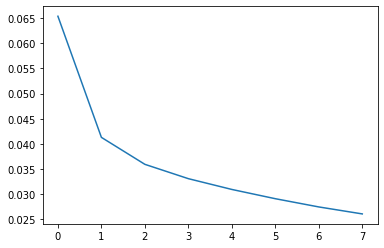

In [67]:
plt.figure()
x = [loss_map[i][0] for i in range(len(loss_map))]
y = [loss_map[i][1] for i in range(len(loss_map))]
plt.plot(x,y)
plt.show()


Classification metrics is useful in predicting how good the model is